### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [1]:
import mlflow
import os
import matplotlib.pyplot as plt
from phik import resources, report
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "project228_2"
RUN_NAME = 'run_artifact_EDA'
ARTIFACT_DIR = "ARTIFACT_EDA"
DATA_DIR_PATH = '/home/mle-user/mle-pipeline-model-development/data'
CV_RESULTS_PATH = "/home/mle-user/mle-pipeline-model-development/cv_results"
notebook_path = "/home/mle-user/mle-pipeline-model-development/model_improvement/project_template_sprint_2.ipynb"
conclusion_path = "/home/mle-user/mle-pipeline-model-development/model_improvement/colclusion_EDA.md"

pd.options.display.max_columns = 70

# устанавливаем соединение с mlflow API
client = mlflow.MlflowClient(tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
                             registry_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# получаем уникальный номер эксперимента по имени
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# создание директории для артефактов
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [2]:
# сделайте разделение изначального набора данных в этой ячейке


import psycopg2 as psycopg
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

connection = {"host": os.getenv("DB_DESTINATION_HOST"),
              'port': os.getenv("DB_DESTINATION_PORT"),
              "dbname": os.getenv("DB_DESTINATION_NAME"),
              "user": os.getenv("DB_DESTINATION_USER"),
              "password": os.getenv("DB_DESTINATION_PASSWORD"),
              'sslmode': 'require',
              'target_session_attrs': 'read-write'}

TABLE_NAME = 'clean_dataset_build_price_2'

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f'SELECT * FROM {TABLE_NAME}')
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

data = pd.DataFrame(data, columns=columns)


In [3]:
# Проведу логарифмирование таргета до разделения выборок

In [4]:
data = data.drop(['id'], axis=1)

In [5]:
data['price'] = data['price'].astype('int')

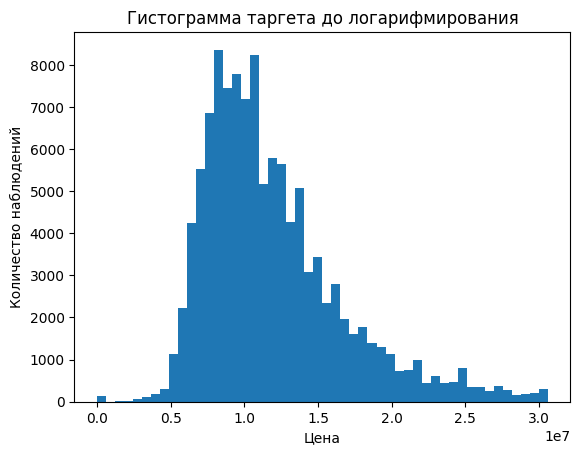

In [6]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета до логарифмирования')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_before.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)


In [7]:
# поскольку таргет имеет большой размах, то считаю,
# что хорошо подойдет разбиение на train/test с кросс-валидацией
# учитывая разбиение по таргету с помощью квантилей

# Прежде чем применять логарифмирование, убедитесь, что все значения целевой переменной положительные, так как логарифм от нуля или отрицательного числа не определен.

# 1. **Сильный разброс значений таргета**: Если значения таргета варьируются в широком диапазоне, логарифмирование может помочь уменьшить этот разброс.
# 2. **Смещение распределения**: Если распределение таргета сильно асимметрично (например, с длинным правым хвостом), логарифмирование может сделать его более симметричным.


import numpy as np
from sklearn.model_selection import train_test_split

data['price'] = np.log1p(data['price'])


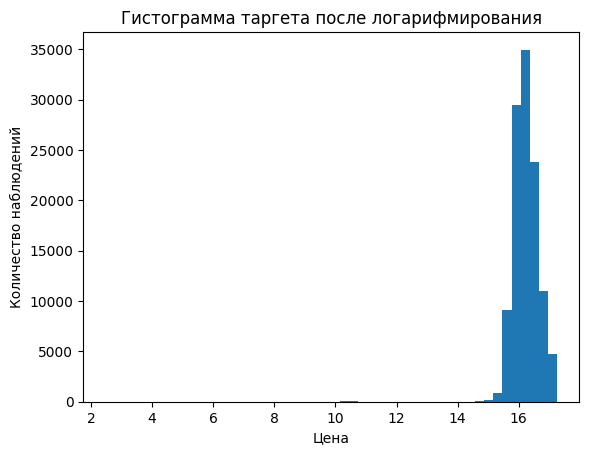

In [8]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета после логарифмирования')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_after.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)



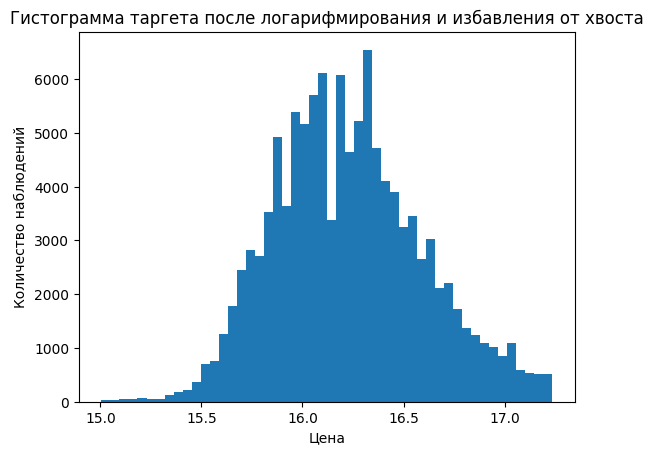

In [9]:
# предлагаю выравнять распрделение и избавиться от хвоста

data = data.query('price >= 15')


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета после логарифмирования и избавления от хвоста')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_after_and_tail.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)

In [10]:
train, test = train_test_split(data.drop(['id_build_flat'], axis=1), shuffle=True, test_size=0.3, random_state=42)

<Axes: ylabel='Frequency'>

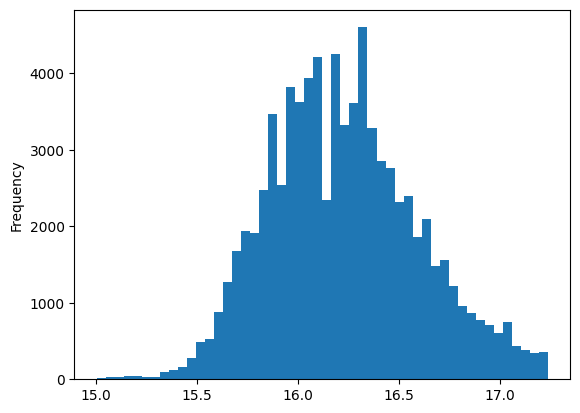

In [11]:
train['price'].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

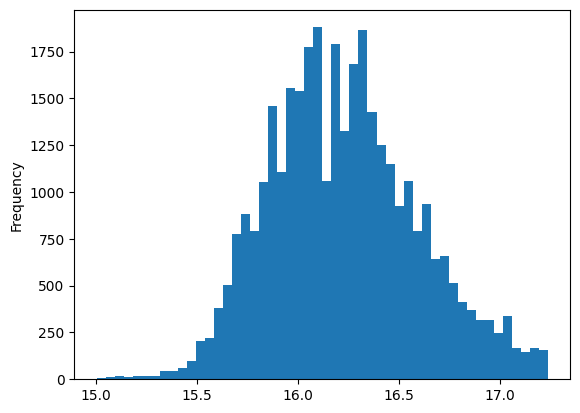

In [12]:
test['price'].plot.hist(bins=50)

In [13]:
# распределение сохранилось

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [14]:
# 2.1 Загрузка данных.
# Выше мы уже провели начальный выгрузку данных из БД и логарифмирование таргета и разделение на выборки
# EDA всегда проводится на train, изучим его подробнее

train

,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,house_age
44177,4,2.64,127,16,true,14,8.5,20.000000,1,false,36.500000,16.097893,42
77431,4,2.64,119,5,false,5,5.5,28.900000,2,false,41.660000,16.213406,57
16341,4,2.48,105,16,true,3,9.6,0.000000,1,false,34.000000,16.162113,45
60207,4,2.64,210,12,true,5,5.6,14.200000,1,false,28.700001,15.843659,24
90918,1,2.70,350,9,true,9,5.7,23.799999,2,false,38.000000,16.045525,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76988,4,2.74,192,25,true,11,13.0,32.200001,2,false,62.400002,16.543363,9
110543,4,2.64,255,16,true,16,10.0,45.000000,3,false,74.000000,16.296242,46
103937,4,2.64,239,14,true,4,10.1,44.799999,3,false,73.800003,16.475770,28
860,4,2.48,204,16,true,1,11.3,28.299999,2,false,53.900002,16.418200,50


In [15]:
# 2.2. Общий обзор датасета

train.info()

# Видим, что пропусков нет.
# 3 типа object, building_type_int оставим в этом типе, будем применять target_encoding

<class 'pandas.core.frame.DataFrame'>
Index: 79798 entries, 44177 to 15810
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_type_int  79798 non-null  object 
 1   ceiling_height     79798 non-null  float64
 2   flats_count        79798 non-null  int64  
 3   floors_total       79798 non-null  int64  
 4   has_elevator       79798 non-null  object 
 5   floor              79798 non-null  int64  
 6   kitchen_area       79798 non-null  float64
 7   living_area        79798 non-null  float64
 8   rooms              79798 non-null  int64  
 9   is_apartment       79798 non-null  object 
 10  total_area         79798 non-null  float64
 11  price              79798 non-null  float64
 12  house_age          79798 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 8.5+ MB


In [16]:
# Посмотрим распредления признаков

train.describe()



# видим высокий разброс в фиче flats_count, далее подробнее изучим ее распрделение
# В среднем, высота потолка около 2.7м
# Больше всего 2 комнатных квартир
# Средняя площадь квартиры 52м2
# Средний возраст дома 39 лет
# Средняя цена 16.227826 (логарифмированное) -> около 11 миллионов


# Таким образом, общая картина по квартирам такая: чаще всего продают 2 комантные квартиры площадью 52м2,
#  с возрастом дома 39 лет за 11 миллионов в среднем

,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,price,house_age
count,79798.000000,79798.000000,79798.000000,79798.000000,79798.000000,79798.000000,79798.000000,79798.000000,79798.000000,79798.000000
mean,2.690004,228.582897,13.156432,6.837465,8.190424,27.761578,1.958132,52.157428,16.227826,39.438056
std,0.132421,141.162623,5.194557,4.620668,3.036139,14.738716,0.824113,16.736130,0.367387,19.565050
min,2.400000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,13.000000,15.004878,1.000000
25%,2.640000,112.000000,9.000000,3.000000,6.000000,19.000000,1.000000,38.500000,15.955577,21.000000
50%,2.640000,196.000000,12.000000,6.000000,8.500000,28.600000,2.000000,49.099998,16.204273,44.000000
75%,2.740000,310.000000,17.000000,10.000000,10.000000,36.849998,3.000000,61.299999,16.461685,55.000000
max,3.070000,686.000000,30.000000,21.000000,17.139999,79.200000,6.000000,127.000000,17.236511,119.000000


In [17]:
result = 16.227826
x = np.exp(result) - 1
print(x)

11159770.055869777


In [18]:
# проверим, что в данных нет абсолютных дубликатов

train.drop_duplicates()


,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,house_age
44177,4,2.64,127,16,true,14,8.5,20.000000,1,false,36.500000,16.097893,42
77431,4,2.64,119,5,false,5,5.5,28.900000,2,false,41.660000,16.213406,57
16341,4,2.48,105,16,true,3,9.6,0.000000,1,false,34.000000,16.162113,45
60207,4,2.64,210,12,true,5,5.6,14.200000,1,false,28.700001,15.843659,24
90918,1,2.70,350,9,true,9,5.7,23.799999,2,false,38.000000,16.045525,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76988,4,2.74,192,25,true,11,13.0,32.200001,2,false,62.400002,16.543363,9
110543,4,2.64,255,16,true,16,10.0,45.000000,3,false,74.000000,16.296242,46
103937,4,2.64,239,14,true,4,10.1,44.799999,3,false,73.800003,16.475770,28
860,4,2.48,204,16,true,1,11.3,28.299999,2,false,53.900002,16.418200,50


In [19]:



# как видим, несколько тысяч записей оказались дубликатами, удалим их
train = train.drop_duplicates()

In [20]:
# ! pip install phik

In [21]:
# 2.3 Анализ признаков для модели

In [22]:
#  Phi_K является обобщением коэффициента корреляции Пирсона и предназначен для более точного измерения ассоциаций в данных,
#  где традиционные методы могут быть неэффективны.

# ### Когда использовать Phi_K (φk)

# 1. **Смешанные типы данных:** Когда у вас есть как числовые, так и категориальные признаки, и вы хотите понять их взаимосвязь.
# 2. **Нелинейные зависимости:** Phi_K может обнаруживать нелинейные зависимости, которые могут быть упущены традиционными методами корреляции.
# 3. **Большое количество уникальных значений:** Если у вас есть категориальные признаки с большим количеством уникальных значений, стандартные методы, такие как коэффициент Cramer’s V, могут быть неэффективны.
# 4. **Неравномерное распределение:** Phi_K хорошо справляется с неравномерно распределенными данными, где частотные методы могут давать искаженные результаты.

interval columns not set, guessing: ['ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area', 'living_area', 'rooms', 'total_area', 'price', 'house_age']


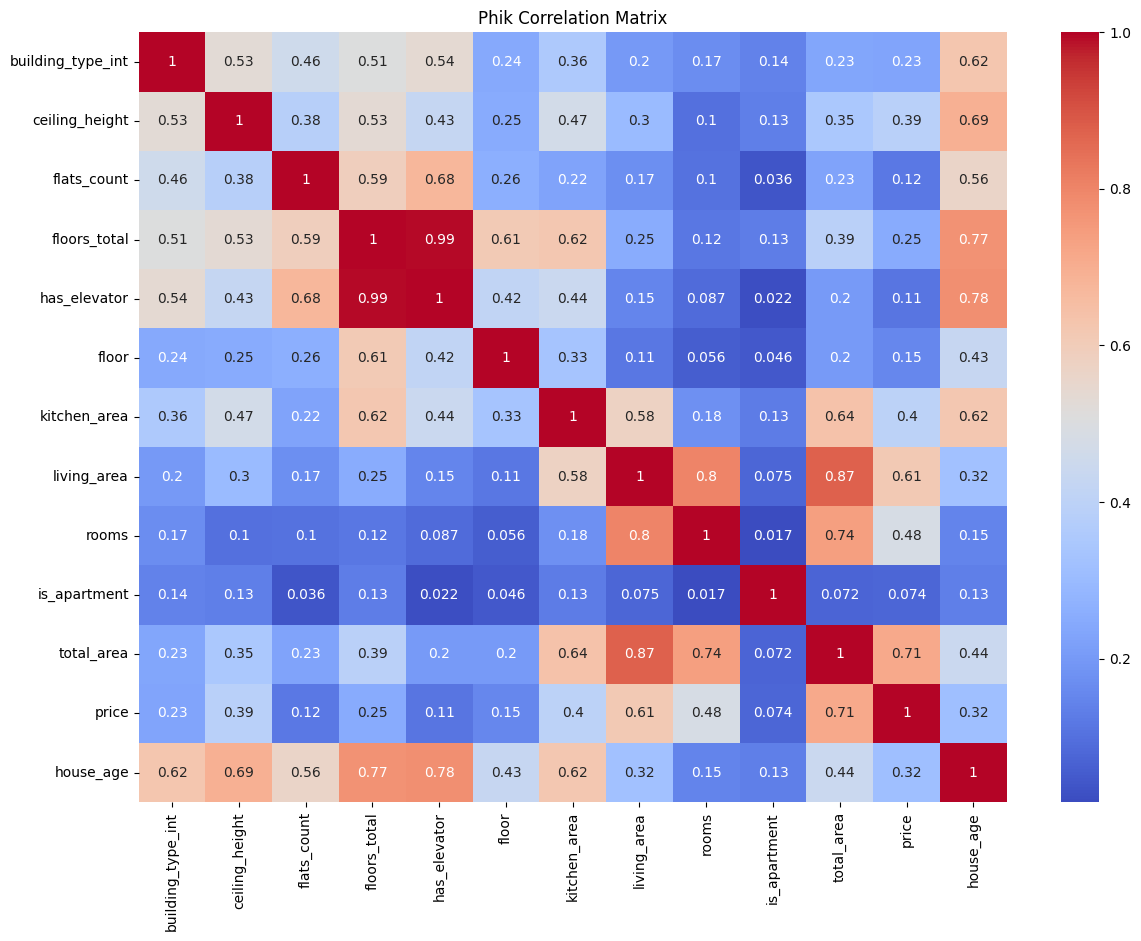

In [23]:
# проведем общий анализ фичей
# Построим корреляционную матрицу


# Вычислим матрицу корреляций phik
phik_matrix = train.phik_matrix()


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    plt.figure(figsize=(14, 10))
    sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
    plt.title("Phik Correlation Matrix")
    image_path = os.path.join(ARTIFACT_DIR, f"phik_correlation_matrix.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)


In [24]:


# как видим из heatmap для phik:
# 
# 
# 
# Из интересного сразу видим прямую зависимость между тем, есть ли лифт и количеству этажей!))
# также видим связь между возрастом дома, этажами и лифтом, предположу, что чем старше дом, тем меньше домов были с лифтами

In [25]:
# интересно посмотреть на связь между высотой потолка и возрастом дома

train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)

# Группировка и агрегация
grouped = train.groupby('ceiling_height_bin')['house_age'].agg(['mean', 'count']).reset_index()
grouped



# как видим, в новостройках высота потолков выше и равна 2.7м

/tmp/ipykernel_4210/87589859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)


,ceiling_height_bin,mean,count
0,"(2.399, 2.64]",45.485444,46751
1,"(2.64, 2.7]",31.613351,10366
2,"(2.7, 3.07]",29.130382,19113


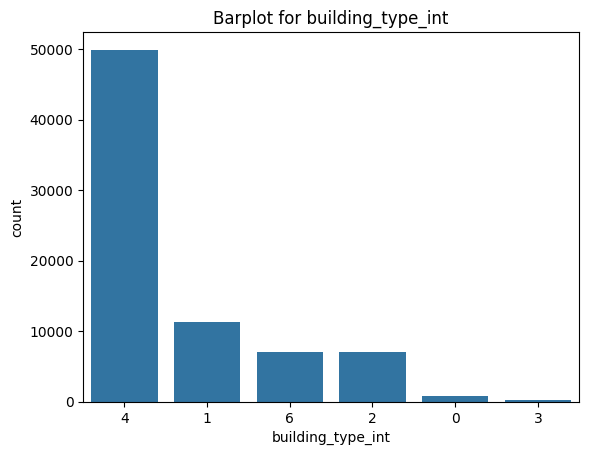

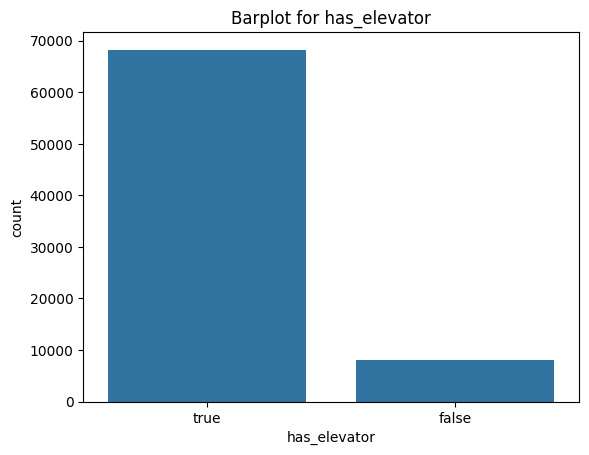

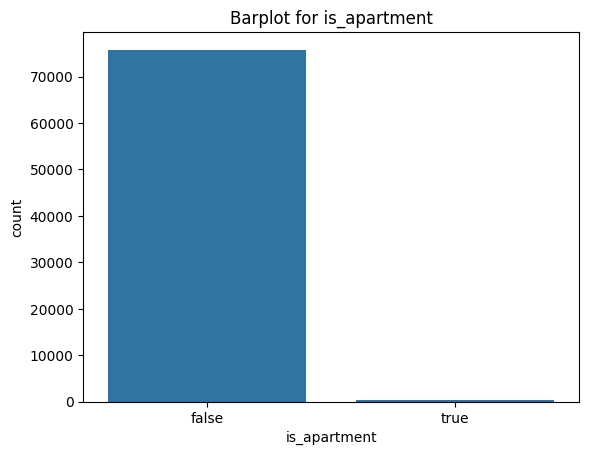

In [26]:
# рассмотрим категориальне фичи по отдельности

categorical_features = ['building_type_int', 'has_elevator', 'is_apartment']

# Построение barplot для категориальных фичей

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    for feature in categorical_features:
        sns.countplot(data=train, x=feature)
        plt.title(f'Barplot for {feature}')
        image_path = os.path.join(ARTIFACT_DIR, f"{feature}_barplot.png")
        plt.savefig(image_path)
        mlflow.log_artifact(image_path)
        plt.show()
        # close закрывает работу с текущим изображением и освобождает память новому
        plt.close()



# Из столбчатых диаграм видно, что преобладает 4 тип строения (хотя нам это ни о чем не говорит, в описании нет данных, стоит запросить у аналитиков)
# В преобладающей части домой в данных присутствует лифт, в старых зданиях он есть не везде
# В данных практически нет апартаментов

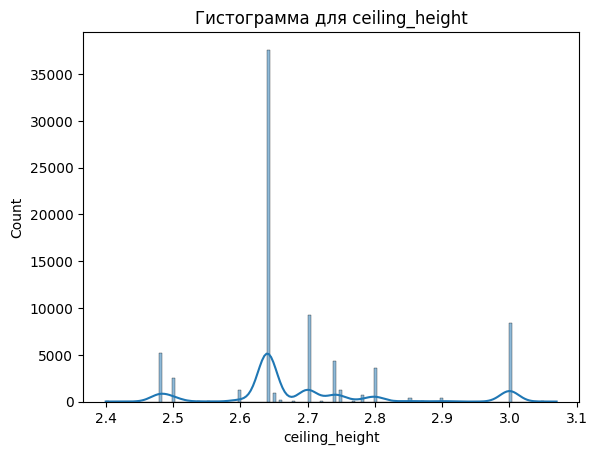

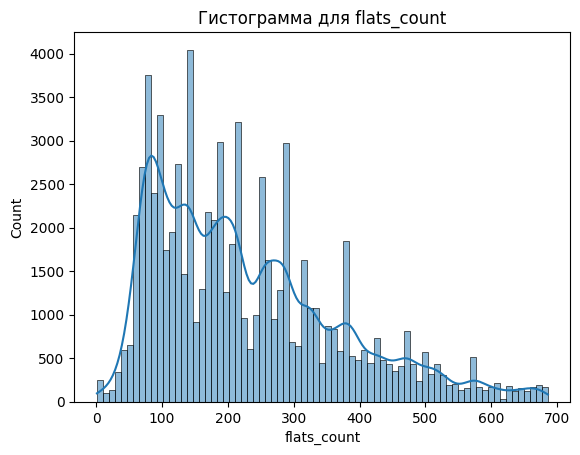

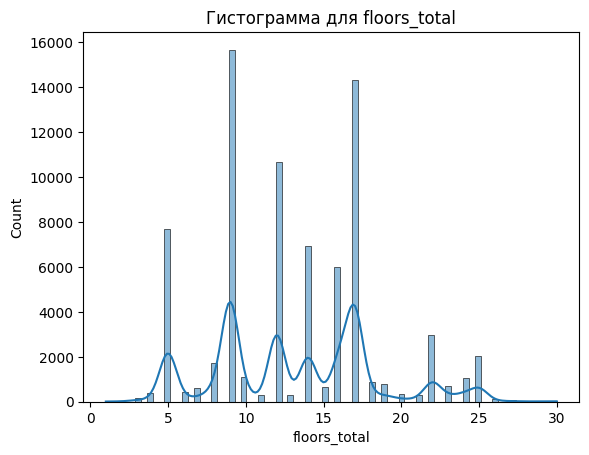

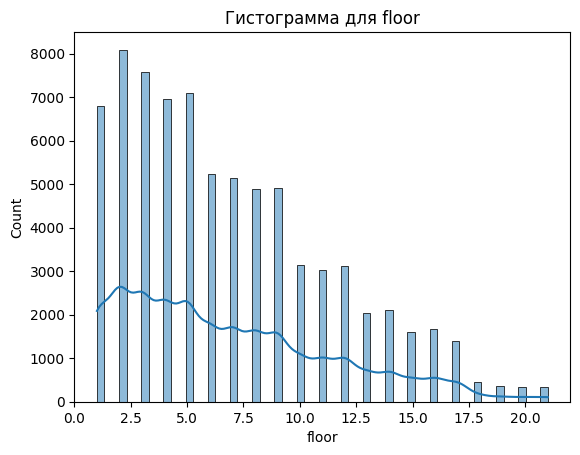

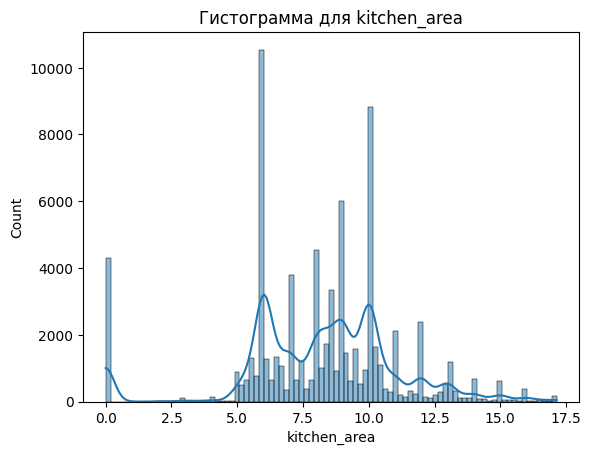

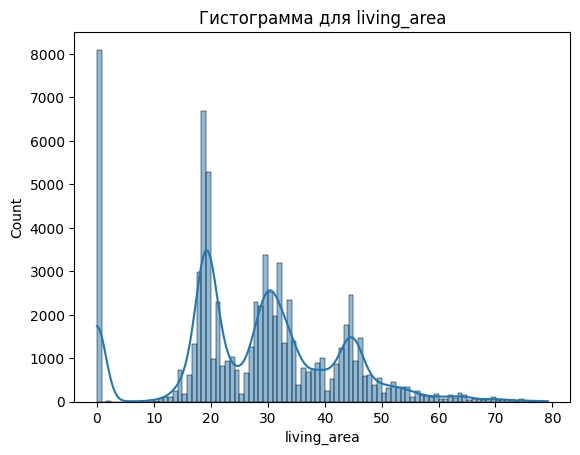

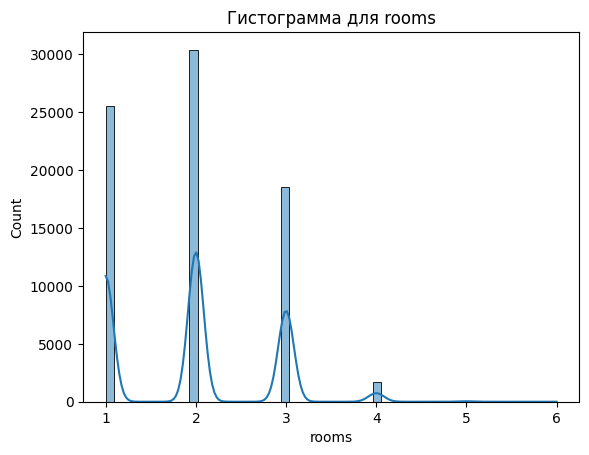

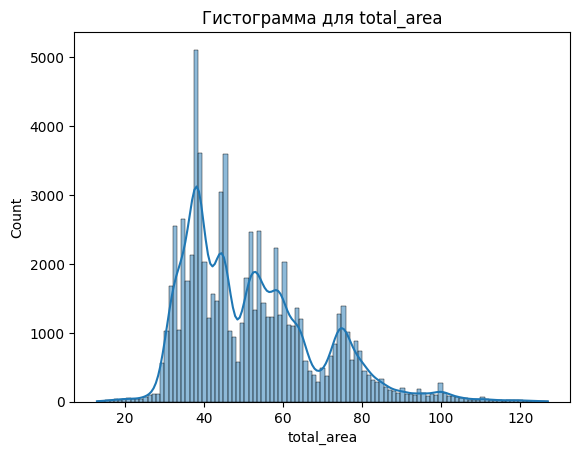

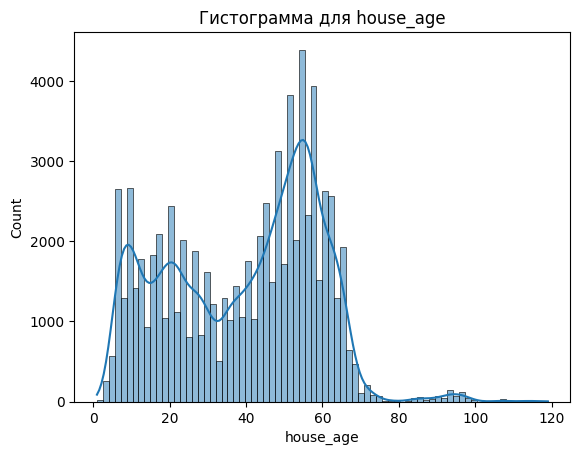

In [27]:
numerical_features = ['ceiling_height', 'flats_count', 'floors_total',
                      'floor', 'kitchen_area', 'living_area', 'rooms',
                      'total_area', 'house_age']
# Построение histplot для числовых значений
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    for feature in numerical_features:
        sns.histplot(data=train, x=feature, kde=True)
        plt.title(f'Гистограмма для {feature}')
        image_path = os.path.join(ARTIFACT_DIR, f"{feature}_histplot.png")
        plt.savefig(image_path)
        mlflow.log_artifact(image_path)
        plt.show()
        # close закрывает работу с текущим изображением и освобождает память новому
        plt.close()


# из интересного - есть наблюдения, где очень маленькие жилая площадь и кухня, предположу, что это студии
# в них они не считаются в расчете.

# так же в высоте потолков видим пик около 2.65, стандартаная высота потолков в домах

# преобладают квартиры от 1 до 3 комнат, самые распространенные варианты

# также в основном дома продают не старше 70 лет, поскольку потом жилье считается аварийным

In [28]:
# Построение scatterplot для некоторых фичей
scatter_features = ['ceiling_height', 'house_age']  # замените на названия ваших фичей

x = train['ceiling_height']
y = train['house_age']

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    sns.jointplot(x=x, y=y, kind='scatter', color='blue')
    plt.xlabel('Высота потолков')
    plt.ylabel('Возраст дома')
    image_path = os.path.join(ARTIFACT_DIR, f"ceiling_height_house_age_jointplot.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()


# Можем заметить, что очень высокие потолки встречаются в старых домах

In [ ]:
# 2.4 Анализ целевой переменной

<Axes: ylabel='Frequency'>

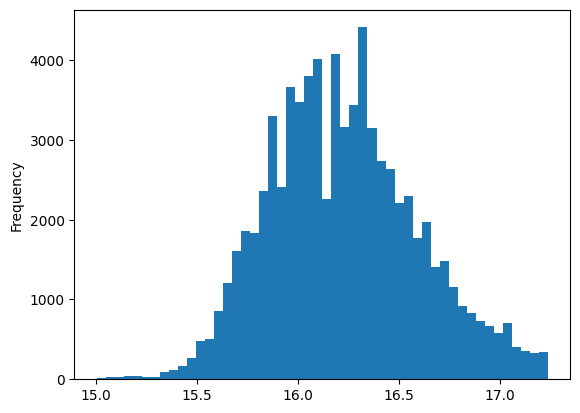

In [ ]:
# После логарифмирования распредление целевой переменной выглядит так

train['price'].plot.hist(bins=50)

# Распределение имеет небольшой хвост слева. Благодаря лагорифмированию мы избавились от огромного диапазона значений

In [ ]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [ ]:
# По анализу phik можем сказать, что особое влияние на цену квартиры оказывают:
# общая площадь квартиры
# количество комнат
# жилая площадь
# площадь кухни
# высота потолков

# 5 этих фичи показывают наибольшую зависимость с таргетом

In [ ]:
# построим 5 сводных таблиц, чтобы оценить влияние этих признаков на цену
# но для начала эти числовые значения нужно разбить на интервалы



In [ ]:
train.columns

Index(['building_type_int', 'ceiling_height', 'flats_count', 'floors_total',
       'has_elevator', 'floor', 'kitchen_area', 'living_area', 'rooms',
       'is_apartment', 'total_area', 'price', 'house_age',
       'ceiling_height_bin'],
      dtype='object')

In [ ]:
# сначала рассмотрим зависимость цены от общей площади, разобьем с помощью qcut

train['total_area_bin'] = pd.qcut(train['total_area'], q=4)

# Группировка и агрегация
grouped = train.groupby('total_area_bin')['price'].agg(['mean', 'count']).reset_index()
grouped

# как видим, чем больше общая площадь, тем больше цена, логично)


/tmp/ipykernel_4249/3170439951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['total_area_bin'] = pd.qcut(train['total_area'], q=4)


,total_area_bin,mean,count
0,"(12.999, 38.5]",15.939766,19204
1,"(38.5, 49.0]",16.082933,18954
2,"(49.0, 61.1]",16.313781,19031
3,"(61.1, 127.0]",16.572559,19041


In [ ]:
# для комнат, площади кухни аналогично, а вот проверим высоту потолков

train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)

# Группировка и агрегация
grouped = train.groupby('ceiling_height_bin')['price'].agg(['mean', 'count']).reset_index()
grouped

# как видим, цена выше там, где больше высота потолков

/tmp/ipykernel_4249/2784045690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)


,ceiling_height_bin,mean,count
0,"(2.399, 2.64]",16.153424,46751
1,"(2.64, 2.7]",16.255395,10366
2,"(2.7, 3.07]",16.390764,19113


# 2.5 Выводы после EDA

Видим, что пропусков в данных нет, значит этап с Airflow отработал корректно. Удалил дубликаты из датасета, это улучшит обобщаю способность модели.



Имеем типа object: из которого признак building_type_int оставим в этом типе, к нему будем применять target_encoding. Что означает этот признак
с его значениями непонятно, стоит обратиться к аналитикам за объяснениями.



Проведя статистический анализ фичей приходим к таким выводам:
* видим высокий разброс в фиче flats_count.
* В среднем, высота потолка около 2.7м
* Больше всего 2 комнатных квартир
* Средняя площадь квартиры 52м2
* Средний возраст дома 39 лет
* Средняя цена 16.227826 (логарифмированное) -> около 11 миллионов



Таким образом, **общая картина по квартирам такая**: чаще всего продают 2 комантные квартиры площадью 52м2, с возрастом дома 39 лет за 11 миллионов в среднем.



Из столбчатых диаграм видно, что преобладает 4 тип строения (хотя нам это ни о чем не говорит, в описании нет данных, стоит запросить у аналитиков)
В преобладающей части домой в данных присутствует лифт, в старых зданиях он есть не везде
В данных практически нет апартаментов.



Из интересного в гистограммах - есть наблюдения, где очень маленькие жилая площадь и кухня, предположу, что это студии.
Так же в высоте потолков видим пик около 2.65, стандартаная высота потолков в домах.
Преобладают квартиры от 1 до 3 комнат, самые распространенные варианты
также в основном дома продают не старше 70 лет, поскольку потом жилье считается аварийным



По jointpltot Можем заметить, что очень высокие потолки встречаются в старых домах.


Проведя анализ с помощью phik можем сказать следующее:
Из интересного сразу видим прямую зависимость между тем, есть ли лифт и количеству этажей!))
также видим связь между возрастом дома, этажами и лифтом, предположу, что чем старше дом, тем меньше домов были с лифтами
как видим, в новостройках высота потолков выше и равна 2.7м

По анализу phik можем сказать, **что особое влияние на цену квартиры оказывают:**
* общая площадь квартиры
* количество комнат
* жилая площадь
* площадь кухни
* высота потолков


Как видим, чем больше общая площадь, тем больше цена, логично) для комнат, площади кухни аналогично. Цена также выше там, где больше высота потолков. Возможно, элитное жилье.

**Распределение целевой переменной имеет небольшой хвост слева. Благодаря логарифмированию мы избавились от огромного диапазона значений!**


In [ ]:
# 2.6 логирование артефактов в MLflow

In [ ]:
# создание нового запуска для логирования файлов

with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
    local_conclusion_path = os.path.join(ARTIFACT_DIR, "conclusion_EDA.md")
    os.system(f"cp {conclusion_path} {local_conclusion_path}")
    # Логирование файла conclusion_EDA.md
    mlflow.log_artifact(local_conclusion_path)

    # Копирование Jupyter Notebook в директорию артефактов
    local_notebook_path = os.path.join(ARTIFACT_DIR, "notebook.ipynb")
    os.system(f"cp {notebook_path} {local_notebook_path}")
    # Логирование Jupyter Notebook
    mlflow.log_artifact(local_notebook_path)
    print("Артефакты успешно зарегистрированы в mlflow и сохранены локально в папку ARTIFACT_EDA.")



Артефакты успешно зарегистрированы в mlflow и сохранены локально в папку ARTIFACT_EDA.


#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [39]:
# признаки, которые я разбивал по квантилям в датасете имеют тип category, учту это, чтобы в select_dtypes они не попали
train

,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,house_age,ceiling_height_bin,total_area_bin
44177,4,2.64,127,16,true,14,8.5,20.000000,1,false,36.500000,16.097893,42,"(2.399, 2.64]","(12.999, 38.5]"
77431,4,2.64,119,5,false,5,5.5,28.900000,2,false,41.660000,16.213406,57,"(2.399, 2.64]","(38.5, 49.0]"
16341,4,2.48,105,16,true,3,9.6,0.000000,1,false,34.000000,16.162113,45,"(2.399, 2.64]","(12.999, 38.5]"
60207,4,2.64,210,12,true,5,5.6,14.200000,1,false,28.700001,15.843659,24,"(2.399, 2.64]","(12.999, 38.5]"
90918,1,2.70,350,9,true,9,5.7,23.799999,2,false,38.000000,16.045525,53,"(2.64, 2.7]","(12.999, 38.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76988,4,2.74,192,25,true,11,13.0,32.200001,2,false,62.400002,16.543363,9,"(2.7, 3.07]","(61.1, 127.0]"
110543,4,2.64,255,16,true,16,10.0,45.000000,3,false,74.000000,16.296242,46,"(2.399, 2.64]","(61.1, 127.0]"
103937,4,2.64,239,14,true,4,10.1,44.799999,3,false,73.800003,16.475770,28,"(2.399, 2.64]","(61.1, 127.0]"
860,4,2.48,204,16,true,1,11.3,28.299999,2,false,53.900002,16.418200,50,"(2.399, 2.64]","(49.0, 61.1]"


In [40]:
train.values[0]

array(['4', 2.640000104904175, 127, 16, 'true', 14, 8.5, 20.0, 1, 'false',
       36.5, 16.097893045681612, 42,
       Interval(2.399, 2.64, closed='right'),
       Interval(12.999, 38.5, closed='right')], dtype=object)

In [41]:
train.dtypes

building_type_int       object
ceiling_height         float64
flats_count              int64
floors_total             int64
has_elevator            object
floor                    int64
kitchen_area           float64
living_area            float64
rooms                    int64
is_apartment            object
total_area             float64
price                  float64
house_age                int64
ceiling_height_bin    category
total_area_bin        category
dtype: object

**Масштабирование и другие преобразования не стоит делать до создания новых фичей, поскольку так мы можем получить новый объекты, которые будет сложнее интерпретировать или которые станут менее значимыми, поскольку преобразование масштабирования/... может изменить отношения между переменными.**

Для ручного Feature Engineering буду использовать фичи:
* kitchen_area
* living_area
* total_area
* house_age
* ceiling_height

Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer


Если у нас есть 5 исходных признаков: kitchen_area, living_area, total_area, и house_age, ceiling_height то полиномиальные признаки второй степени будут включать:
- Все исходные признаки (1 степень): kitchen_area, living_area, total_area, house_age, ceiling_height
- Квадраты каждого признака (2 степень): kitchen_area^2, living_area^2, total_area^2, house_age^2, ceiling_height^2
- Все возможные пары взаимодействий (произведения признаков): kitchen_area \* living_area, kitchen_area \* total_area, и т.д.


KBinsDiscretizer делит каждый числовой признак на несколько интервалов (бинов). В вашем случае используется параметр n_bins=5, что означает деление каждого признака на 5 бинов. То есть, число фичей будет 5
Таким образом, будет создано 4 новых признака:
- kbins_kitchen_area
- kbins_living_area
- kbins_total_area
- kbins_house_age
- kbins_ceiling_height


SplineTransformer создает сплайн-признаки для каждого числового признака. В вашем случае используется параметр n_knots=3, что означает создание 3 узлов (knots). По умолчанию, это приводит к созданию ( n_knots + degree - 1) новых признаков для каждого исходного признака (где degree по умолчанию равен 3). Значит у нас создастся 6 новых фичей для каждого признака)



In [42]:
# Выделение признаков для предобработки
train = train.drop(['ceiling_height_bin', 'total_area_bin'], axis=1)


In [43]:
train.columns

Index(['building_type_int', 'ceiling_height', 'flats_count', 'floors_total',
       'has_elevator', 'floor', 'kitchen_area', 'living_area', 'rooms',
       'is_apartment', 'total_area', 'price', 'house_age'],
      dtype='object')

In [44]:
# 3.1 ручная генерация признаков


In [45]:
# Используем ручной FE для создания новых признаков на основе этих
# Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer

# Используем ручной FE для создания новых признаков на основе этих
# Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, SplineTransformer, OneHotEncoder, StandardScaler
from category_encoders import CatBoostEncoder


feature_for_manual = ['kitchen_area', 'living_area', 'total_area', 'house_age', 'ceiling_height']

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
kbins_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
spline_transformer = SplineTransformer(n_knots=3, degree=3)


In [46]:
train.dtypes

building_type_int     object
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator          object
floor                  int64
kitchen_area         float64
living_area          float64
rooms                  int64
is_apartment          object
total_area           float64
price                float64
house_age              int64
dtype: object

In [47]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [48]:
# Объединение ручных трансформеров с использованием ColumnTransformer
preprocessor_manual = ColumnTransformer(transformers=[
    ('poly', poly_transformer, feature_for_manual),
    ('kbins', kbins_transformer, feature_for_manual),
    ('spline', spline_transformer, feature_for_manual),
    
], remainder='passthrough', verbose_feature_names_out=True)

pipeline_for_manual_feature_engineering = Pipeline(steps=[
    ('preprocessor', preprocessor_manual),
])

pipeline_for_manual_feature_engineering.fit(train)
# Применение пайплайна к данным. На transform это также будет 1 этапом
list_names_features = pipeline_for_manual_feature_engineering.named_steps['preprocessor'].get_feature_names_out()
train_manual = pd.DataFrame(pipeline_for_manual_feature_engineering.transform(train),
                                                                                               columns=list_names_features)

train_manual

/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,remainder__price
0,8.5,20.0,36.5,42.0,2.64,72.25,170.0,310.25,357.0,22.440001,400.0,730.0,840.0,52.800002,1332.25,1533.0,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,0.0,0.170784,0.6666,0.162616,0.0,0.020208,0.476004,0.482317,0.021471,0.0,0.033834,0.53173,0.422756,0.01168,0.0,0.004733,0.351549,0.587788,0.05593,0.0,0.003801,0.337264,0.597651,0.061284,0.0,4,127,16,true,14,1,false,16.097893
1,5.5,28.9,41.66,57.0,2.64,30.25,158.949998,229.129999,313.5,14.520001,835.209978,1203.97398,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,0.007662,0.386958,0.561325,0.044055,0.0,0.003288,0.328409,0.603521,0.064782,0.0,0.020484,0.47741,0.480919,0.021186,0.0,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.0,4,119,5,false,5,2,false,16.213406
2,9.6,0.0,34.0,45.0,2.48,92.160007,0.0,326.400013,432.000017,23.808001,0.0,0.0,0.0,0.0,1156.0,1530.0,84.320001,2025.0,111.600001,6.1504,2.0,0.0,0.0,1.0,0.0,0.0,0.113506,0.65309,0.233114,0.000289,0.166667,0.666667,0.166667,0.0,0.0,0.041989,0.555936,0.393741,0.008335,0.0,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.00227,0.0,4,105,16,true,3,1,false,16.162113
3,5.6,14.2,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,0.006937,0.379185,0.567376,0.046502,0.0,0.043981,0.561137,0.387197,0.007685,0.0,0.063398,0.601249,0.331871,0.003483,0.0,0.037862,0.54432,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.0,4,210,12,true,5,1,false,15.843659
4,5.7,23.799999,38.0,53.0,2.7,32.489998,135.659991,216.599993,302.09999,15.39,566.439964,904.399971,1261.39996,64.259999,1444.0,2014.0,102.600002,2809.0,143.100003,7.29,1.0,1.0,1.0,2.0,2.0,0.00626,0.371408,0.573295,0.049038,0.0,0.010586,0.414,0.539232,0.036182,0.0,0.02949,0.516486,0.439963,0.014062,0.0,0.000278,0.232192,0.653425,0.114104,0.0,0.00019,0.223793,0.656321,0.119696,0.0,1,350,9,true,9,2,false,16.045525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76225,13.0,32.200001,62.400002,9.0,2.74,169.0,418.60001,811.20002,117.0,35.62,1036.840049,2009.280097,289.800007,88.228002,3893.76019,561.600014,170.976005,81.0,24.66,7.5076,3.0,2.0,2.0,0.0,2.0,0.0,0.018789,0.468523,0.489667,0.023021,0.001088,0.274298,0.635009,0.089605,0.0,0.000395,0.241037,0.650074,0.108494,0.0,0.10

**Поскольку после PolynomialFeatures мы получаем свою же фичу, но в 1 степени, то наши фичи, к которым применяли преобразование будут иметь приставку poly__**

**Также получаем вторую проблему, что после преобразований в ColumnTransformer все наши фичи стали типа object, их необходимо перевести в нужный нам тип**

In [49]:
train_manual

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,remainder__price
0,8.5,20.0,36.5,42.0,2.64,72.25,170.0,310.25,357.0,22.440001,400.0,730.0,840.0,52.800002,1332.25,1533.0,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,0.0,0.170784,0.6666,0.162616,0.0,0.020208,0.476004,0.482317,0.021471,0.0,0.033834,0.53173,0.422756,0.01168,0.0,0.004733,0.351549,0.587788,0.05593,0.0,0.003801,0.337264,0.597651,0.061284,0.0,4,127,16,true,14,1,false,16.097893
1,5.5,28.9,41.66,57.0,2.64,30.25,158.949998,229.129999,313.5,14.520001,835.209978,1203.97398,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,0.007662,0.386958,0.561325,0.044055,0.0,0.003288,0.328409,0.603521,0.064782,0.0,0.020484,0.47741,0.480919,0.021186,0.0,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.0,4,119,5,false,5,2,false,16.213406
2,9.6,0.0,34.0,45.0,2.48,92.160007,0.0,326.400013,432.000017,23.808001,0.0,0.0,0.0,0.0,1156.0,1530.0,84.320001,2025.0,111.600001,6.1504,2.0,0.0,0.0,1.0,0.0,0.0,0.113506,0.65309,0.233114,0.000289,0.166667,0.666667,0.166667,0.0,0.0,0.041989,0.555936,0.393741,0.008335,0.0,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.00227,0.0,4,105,16,true,3,1,false,16.162113
3,5.6,14.2,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,0.006937,0.379185,0.567376,0.046502,0.0,0.043981,0.561137,0.387197,0.007685,0.0,0.063398,0.601249,0.331871,0.003483,0.0,0.037862,0.54432,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.0,4,210,12,true,5,1,false,15.843659
4,5.7,23.799999,38.0,53.0,2.7,32.489998,135.659991,216.599993,302.09999,15.39,566.439964,904.399971,1261.39996,64.259999,1444.0,2014.0,102.600002,2809.0,143.100003,7.29,1.0,1.0,1.0,2.0,2.0,0.00626,0.371408,0.573295,0.049038,0.0,0.010586,0.414,0.539232,0.036182,0.0,0.02949,0.516486,0.439963,0.014062,0.0,0.000278,0.232192,0.653425,0.114104,0.0,0.00019,0.223793,0.656321,0.119696,0.0,1,350,9,true,9,2,false,16.045525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76225,13.0,32.200001,62.400002,9.0,2.74,169.0,418.60001,811.20002,117.0,35.62,1036.840049,2009.280097,289.800007,88.228002,3893.76019,561.600014,170.976005,81.0,24.66,7.5076,3.0,2.0,2.0,0.0,2.0,0.0,0.018789,0.468523,0.489667,0.023021,0.001088,0.274298,0.635009,0.089605,0.0,0.000395,0.241037,0.650074,0.108494,0.0,0.10

In [50]:
train_manual.dtypes

poly__kitchen_area                   object
poly__living_area                    object
poly__total_area                     object
poly__house_age                      object
poly__ceiling_height                 object
poly__kitchen_area^2                 object
poly__kitchen_area living_area       object
poly__kitchen_area total_area        object
poly__kitchen_area house_age         object
poly__kitchen_area ceiling_height    object
poly__living_area^2                  object
poly__living_area total_area         object
poly__living_area house_age          object
poly__living_area ceiling_height     object
poly__total_area^2                   object
poly__total_area house_age           object
poly__total_area ceiling_height      object
poly__house_age^2                    object
poly__house_age ceiling_height       object
poly__ceiling_height^2               object
kbins__kitchen_area                  object
kbins__living_area                   object
kbins__total_area               

In [51]:
train_manual.columns

Index(['poly__kitchen_area', 'poly__living_area', 'poly__total_area',
       'poly__house_age', 'poly__ceiling_height', 'poly__kitchen_area^2',
       'poly__kitchen_area living_area', 'poly__kitchen_area total_area',
       'poly__kitchen_area house_age', 'poly__kitchen_area ceiling_height',
       'poly__living_area^2', 'poly__living_area total_area',
       'poly__living_area house_age', 'poly__living_area ceiling_height',
       'poly__total_area^2', 'poly__total_area house_age',
       'poly__total_area ceiling_height', 'poly__house_age^2',
       'poly__house_age ceiling_height', 'poly__ceiling_height^2',
       'kbins__kitchen_area', 'kbins__living_area', 'kbins__total_area',
       'kbins__house_age', 'kbins__ceiling_height',
       'spline__kitchen_area_sp_0', 'spline__kitchen_area_sp_1',
       'spline__kitchen_area_sp_2', 'spline__kitchen_area_sp_3',
       'spline__kitchen_area_sp_4', 'spline__living_area_sp_0',
       'spline__living_area_sp_1', 'spline__living_area_sp_2',

In [52]:
# Исправим типы данных после преобразований

def convert_columns_to_float(df, exclude_columns):
    """
    Преобразует типы всех столбцов в DataFrame на float, кроме указанных в exclude_columns.
    """
    # Создадим список столбцов, которые нужно изменить на float
    columns_to_convert = [col for col in df.columns if col not in exclude_columns]

    df[columns_to_convert] = df[columns_to_convert].astype(float)

    return df



exclude_columns = ['remainder__building_type_int', 'remainder__has_elevator', 'remainder__is_apartment']

# Вызовем функцию для преобразования типов
train_manual = convert_columns_to_float(train_manual, exclude_columns)

In [53]:
train_manual.dtypes

poly__kitchen_area                   float64
poly__living_area                    float64
poly__total_area                     float64
poly__house_age                      float64
poly__ceiling_height                 float64
poly__kitchen_area^2                 float64
poly__kitchen_area living_area       float64
poly__kitchen_area total_area        float64
poly__kitchen_area house_age         float64
poly__kitchen_area ceiling_height    float64
poly__living_area^2                  float64
poly__living_area total_area         float64
poly__living_area house_age          float64
poly__living_area ceiling_height     float64
poly__total_area^2                   float64
poly__total_area house_age           float64
poly__total_area ceiling_height      float64
poly__house_age^2                    float64
poly__house_age ceiling_height       float64
poly__ceiling_height^2               float64
kbins__kitchen_area                  float64
kbins__living_area                   float64
kbins__tot

In [54]:
train_manual.dtypes

poly__kitchen_area                   float64
poly__living_area                    float64
poly__total_area                     float64
poly__house_age                      float64
poly__ceiling_height                 float64
poly__kitchen_area^2                 float64
poly__kitchen_area living_area       float64
poly__kitchen_area total_area        float64
poly__kitchen_area house_age         float64
poly__kitchen_area ceiling_height    float64
poly__living_area^2                  float64
poly__living_area total_area         float64
poly__living_area house_age          float64
poly__living_area ceiling_height     float64
poly__total_area^2                   float64
poly__total_area house_age           float64
poly__total_area ceiling_height      float64
poly__house_age^2                    float64
poly__house_age ceiling_height       float64
poly__ceiling_height^2               float64
kbins__kitchen_area                  float64
kbins__living_area                   float64
kbins__tot

In [55]:
train_manual

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,remainder__price
0,8.5,20.000000,36.500000,42.0,2.64,72.250000,170.000000,310.250000,357.000000,22.440001,400.000000,730.000000,840.000000,52.800002,1332.250000,1533.000000,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,9.082278e-08,0.170784,0.666600,0.162616,0.000000,0.020208,0.476004,0.482317,0.021471,0.000000,0.033834,0.531730,0.422756,0.011680,0.000000,0.004733,0.351549,0.587788,0.055930,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,4,127.0,16.0,true,14.0,1.0,false,16.097893
1,5.5,28.900000,41.660000,57.0,2.64,30.250000,158.949998,229.129999,313.500000,14.520001,835.209978,1203.973980,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,7.661633e-03,0.386958,0.561325,0.044055,0.000000,0.003288,0.328409,0.603521,0.064782,0.000000,0.020484,0.477410,0.480919,0.021186,0.000000,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,4,119.0,5.0,false,5.0,2.0,false,16.213406
2,9.6,0.000000,34.000000,45.0,2.48,92.160007,0.000000,326.400013,432.000017,23.808001,0.000000,0.000000,0.000000,0.000000,1156.000000,1530.000000,84.320001,2025.0,111.600001,6.150400,2.0,0.0,0.0,1.0,0.0,0.000000e+00,0.113506,0.653090,0.233114,0.000289,0.166667,0.666667,0.166667,0.000000,0.000000,0.041989,0.555936,0.393741,0.008335,0.000000,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.002270,0.000000e+00,4,105.0,16.0,true,3.0,1.0,false,16.162113
3,5.6,14.200000,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784000,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,6.937062e-03,0.379185,0.567376,0.046502,0.000000,0.043981,0.561137,0.387197,0.007685,0.000000,0.063398,0.601249,0.331871,0.003483,0.000000,0.037862,0.544320,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,4,210.0,12.0,true,5.0,1.0,false,15.843659
4,5.7,23.799999,38.000000,53.0,2.70,32.489998,135.659991,216.599993,302.099990,15.390000,566.439964,904.399971,1261.399960,64.259999,1444.000000,2014.000000,102.600002,2809.0,143.100003,7.290000,1.0,1.0,1.0,2.0,2.0,6.259678e-03,0.371408,0.573295,0.049038,0.000000,0.010586,0.414000,0.539232,0.036182,0.000000,0.029490,0.516486,0.439963,0.014062,0.000000,0.000278,0.232192,0.653425,0.114104,0.0,0.000190,0.223793,0.656321,0.119696,0.000000e+00,1,350.0,9.0,true,9.0,2.0,false,16.045525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [56]:
# 3.3 автоматическая генерация признаков

**При feateng_steps=1 новые фичи для столбцов не генерировались, решение оказалось повышение числа итераций алгоритма. Более высокий параметр feateng_steps позволяет алгоритму выполнять более глубокий анализ и создавать более сложные признаки.**

Категориальные признаки буду обрабатывать дальше в pipeline отдельно. В библиотеке autofeat нет прямого параметра для отключения обработки категориальных признаков. Поэтому отберем нужные данные для преобразований

In [57]:
feature_for_autofeat = ['poly__kitchen_area',
                        'poly__living_area',
                        'poly__total_area',
                        'poly__house_age',
                        'poly__ceiling_height']

categorical_cols=['remainder__building_type_int', 'remainder__has_elevator', 'remainder__is_apartment']


# код для исключения категориальных данных
train_manual.loc[:, ~train_manual.columns.isin(categorical_cols)]

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__flats_count,remainder__floors_total,remainder__floor,remainder__rooms,remainder__price
0,8.5,20.000000,36.500000,42.0,2.64,72.250000,170.000000,310.250000,357.000000,22.440001,400.000000,730.000000,840.000000,52.800002,1332.250000,1533.000000,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,9.082278e-08,0.170784,0.666600,0.162616,0.000000,0.020208,0.476004,0.482317,0.021471,0.000000,0.033834,0.531730,0.422756,0.011680,0.000000,0.004733,0.351549,0.587788,0.055930,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,127.0,16.0,14.0,1.0,16.097893
1,5.5,28.900000,41.660000,57.0,2.64,30.250000,158.949998,229.129999,313.500000,14.520001,835.209978,1203.973980,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,7.661633e-03,0.386958,0.561325,0.044055,0.000000,0.003288,0.328409,0.603521,0.064782,0.000000,0.020484,0.477410,0.480919,0.021186,0.000000,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,119.0,5.0,5.0,2.0,16.213406
2,9.6,0.000000,34.000000,45.0,2.48,92.160007,0.000000,326.400013,432.000017,23.808001,0.000000,0.000000,0.000000,0.000000,1156.000000,1530.000000,84.320001,2025.0,111.600001,6.150400,2.0,0.0,0.0,1.0,0.0,0.000000e+00,0.113506,0.653090,0.233114,0.000289,0.166667,0.666667,0.166667,0.000000,0.000000,0.041989,0.555936,0.393741,0.008335,0.000000,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.002270,0.000000e+00,105.0,16.0,3.0,1.0,16.162113
3,5.6,14.200000,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784000,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,6.937062e-03,0.379185,0.567376,0.046502,0.000000,0.043981,0.561137,0.387197,0.007685,0.000000,0.063398,0.601249,0.331871,0.003483,0.000000,0.037862,0.544320,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,210.0,12.0,5.0,1.0,15.843659
4,5.7,23.799999,38.000000,53.0,2.70,32.489998,135.659991,216.599993,302.099990,15.390000,566.439964,904.399971,1261.399960,64.259999,1444.000000,2014.000000,102.600002,2809.0,143.100003,7.290000,1.0,1.0,1.0,2.0,2.0,6.259678e-03,0.371408,0.573295,0.049038,0.000000,0.010586,0.414000,0.539232,0.036182,0.000000,0.029490,0.516486,0.439963,0.014062,0.000000,0.000278,0.232192,0.653425,0.114104,0.0,0.000190,0.223793,0.656321,0.119696,0.000000e+00,350.0,9.0,9.0,2.0,16.045525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76225,13.0,32.200001,62.400002,9.0,2.74,169.000000,418.600010,811.200020,117.000000,35.620000,1036.840049,2009.28009

In [58]:
categorical_cols + ['remainder__price']

['remainder__building_type_int',
 'remainder__has_elevator',
 'remainder__is_apartment',
 'remainder__price']

In [59]:
train_manual.loc[:, ~train_manual.columns.isin(categorical_cols + ['remainder__price'])]

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__flats_count,remainder__floors_total,remainder__floor,remainder__rooms
0,8.5,20.000000,36.500000,42.0,2.64,72.250000,170.000000,310.250000,357.000000,22.440001,400.000000,730.000000,840.000000,52.800002,1332.250000,1533.000000,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,9.082278e-08,0.170784,0.666600,0.162616,0.000000,0.020208,0.476004,0.482317,0.021471,0.000000,0.033834,0.531730,0.422756,0.011680,0.000000,0.004733,0.351549,0.587788,0.055930,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,127.0,16.0,14.0,1.0
1,5.5,28.900000,41.660000,57.0,2.64,30.250000,158.949998,229.129999,313.500000,14.520001,835.209978,1203.973980,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,7.661633e-03,0.386958,0.561325,0.044055,0.000000,0.003288,0.328409,0.603521,0.064782,0.000000,0.020484,0.477410,0.480919,0.021186,0.000000,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,119.0,5.0,5.0,2.0
2,9.6,0.000000,34.000000,45.0,2.48,92.160007,0.000000,326.400013,432.000017,23.808001,0.000000,0.000000,0.000000,0.000000,1156.000000,1530.000000,84.320001,2025.0,111.600001,6.150400,2.0,0.0,0.0,1.0,0.0,0.000000e+00,0.113506,0.653090,0.233114,0.000289,0.166667,0.666667,0.166667,0.000000,0.000000,0.041989,0.555936,0.393741,0.008335,0.000000,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.002270,0.000000e+00,105.0,16.0,3.0,1.0
3,5.6,14.200000,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784000,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,6.937062e-03,0.379185,0.567376,0.046502,0.000000,0.043981,0.561137,0.387197,0.007685,0.000000,0.063398,0.601249,0.331871,0.003483,0.000000,0.037862,0.544320,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,210.0,12.0,5.0,1.0
4,5.7,23.799999,38.000000,53.0,2.70,32.489998,135.659991,216.599993,302.099990,15.390000,566.439964,904.399971,1261.399960,64.259999,1444.000000,2014.000000,102.600002,2809.0,143.100003,7.290000,1.0,1.0,1.0,2.0,2.0,6.259678e-03,0.371408,0.573295,0.049038,0.000000,0.010586,0.414000,0.539232,0.036182,0.000000,0.029490,0.516486,0.439963,0.014062,0.000000,0.000278,0.232192,0.653425,0.114104,0.0,0.000190,0.223793,0.656321,0.119696,0.000000e+00,350.0,9.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76225,13.0,32.200001,62.400002,9.0,2.74,169.000000,418.600010,811.200020,117.000000,35.620000,1036.840049,2009.280097,289.800007,88.228002,3893.760190,561.600014,170.976005,81.0,24.660000

In [60]:
from autofeat import AutoFeatRegressor


afc = AutoFeatRegressor(feateng_cols=feature_for_autofeat,
                        feateng_steps=2,
                        max_gb=4,
                        transformations=['1/', 'log', 'abs', 'sqrt'],
                        n_jobs=2)


train_manual_and_autofeat = afc.fit_transform(train_manual.loc[:, ~train_manual.columns.isin(categorical_cols + ['remainder__price'])],
                                              train_manual['remainder__price'])

train_manual_and_autofeat

**Вернем категориальные фичи и таргет в датасет**

In [ ]:
train_extended = pd.concat([train_manual_and_autofeat, train_manual[categorical_cols], train_manual['remainder__price']], axis=1)

In [ ]:
afc.get_params()

{'always_return_numpy': False,
 'apply_pi_theorem': True,
 'categorical_cols': None,
 'feateng_cols': ['poly__kitchen_area',
  'poly__living_area',
  'poly__total_area',
  'poly__house_age',
  'poly__ceiling_height'],
 'feateng_steps': 2,
 'featsel_runs': 5,
 'max_gb': 4,
 'n_jobs': 2,
 'transformations': ['1/', 'log', 'abs', 'sqrt'],
 'units': None,
 'verbose': 0}

In [ ]:
# Залогируем:
# новый датасет после feature engineering
# модель AutoFeatRegressor
# параметры модели autofeat



with mlflow.start_run(run_name='RUN_ARTIFACT_FE', experiment_id=experiment_id) as run:
    csv_path = os.path.join(DATA_DIR_PATH, 'datasets_with_FE.csv')
    train_extended.to_csv(csv_path, index=False)

    mlflow.log_artifact(csv_path)

    mlflow.sklearn.log_model(afc, 'auto_feat_model')
    mlflow.log_params(afc.get_params())

    

In [ ]:
train_extended

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__flats_count,remainder__floors_total,remainder__floor,remainder__rooms,poly__total_area/poly__house_age,poly__house_age/poly__total_area,poly__living_area/poly__house_age,poly__kitchen_area/poly__house_age,poly__kitchen_area/poly__total_area,poly__total_area*log(poly__house_age),poly__kitchen_area*log(poly__house_age),sqrt(poly__living_area)/poly__total_area,log(poly__total_area)/poly__ceiling_height,sqrt(poly__living_area)*log(poly__house_age),remainder__building_type_int,remainder__has_elevator,remainder__is_apartment,remainder__price
0,8.5,20.000000,36.500000,42.0,2.64,72.250000,170.000000,310.250000,357.000000,22.440001,400.000000,730.000000,840.000000,52.800002,1332.250000,1533.000000,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,9.082278e-08,0.170784,0.666600,0.162616,0.000000,0.020208,0.476004,0.482317,0.021471,0.000000,0.033834,0.531730,0.422756,0.011680,0.000000,0.004733,0.351549,0.587788,0.055930,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,127.0,16.0,14.0,1.0,0.869048,1.150685,0.476190,0.202381,0.232877,136.424941,31.770192,0.122524,1.362618,16.715367,4,true,false,16.097893
1,5.5,28.900000,41.660000,57.0,2.64,30.250000,158.949998,229.129999,313.500000,14.520001,835.209978,1203.973980,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,7.661633e-03,0.386958,0.561325,0.044055,0.000000,0.003288,0.328409,0.603521,0.064782,0.000000,0.020484,0.477410,0.480919,0.021186,0.000000,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,119.0,5.0,5.0,2.0,0.730877,1.368219,0.507018,0.096491,0.132021,168.433515,22.236782,0.129042,1.412705,21.734926,4,false,false,16.213406
2,9.6,0.000000,34.000000,45.0,2.48,92.160007,0.000000,326.400013,432.000017,23.808001,0.000000,0.000000,0.000000,0.000000,1156.000000,1530.000000,84.320001,2025.0,111.600001,6.150400,2.0,0.0,0.0,1.0,0.0,0.000000e+00,0.113506,0.653090,0.233114,0.000289,0.166667,0.666667,0.166667,0.000000,0.000000,0.041989,0.555936,0.393741,0.008335,0.000000,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.002270,0.000000e+00,105.0,16.0,3.0,1.0,0.755556,1.323529,0.000000,0.213333,0.282353,129.426525,36.543961,0.000000,1.421920,0.000000,4,true,false,16.162113
3,5.6,14.200000,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784000,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,6.937062e-03,0.379185,0.567376,0.046502,0.000000,0.043981,0.561137,0.387197,0.007685,0.000000,0.063398,0.601249,0.331871,0.003483,0.000000,0.037862,0.544320,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,210.0,12.0,5.0,1.0,1.195833,0.836237,0.591667,0.233333,0.195122,

**Проведем предобработку после Feature Engineering**

In [ ]:
train_extended.dtypes

poly__kitchen_area                              float64
poly__living_area                               float64
poly__total_area                                float64
poly__house_age                                 float64
poly__ceiling_height                            float64
                                                 ...   
sqrt(poly__living_area)*log(poly__house_age)    float64
remainder__building_type_int                     object
remainder__has_elevator                          object
remainder__is_apartment                          object
remainder__price                                float64
Length: 68, dtype: object

In [ ]:
from category_encoders import CatBoostEncoder


y_train = train_extended['remainder__price']
X_train = train_extended.drop(['remainder__price'], axis=1)

cat_features = X_train.select_dtypes(include='object')
potential_binary_features = cat_features.nunique() == 2

binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = X_train.select_dtypes(['float', 'int'])


preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary'), binary_cat_features.columns.tolist()),
        ('cat', CatBoostEncoder(return_df=False), other_cat_features.columns.tolist()),
        ('num', StandardScaler(), num_features.columns.tolist())
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [ ]:
y_train

0        16.097893
1        16.213406
2        16.162113
3        15.843659
4        16.045525
           ...    
76225    16.543363
76226    16.296242
76227    16.475770
76228    16.418200
76229    16.380460
Name: remainder__price, Length: 76230, dtype: float64

In [ ]:
num_features

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__flats_count,remainder__floors_total,remainder__floor,remainder__rooms,poly__total_area/poly__house_age,poly__house_age/poly__total_area,poly__living_area/poly__house_age,poly__kitchen_area/poly__house_age,poly__kitchen_area/poly__total_area,poly__total_area*log(poly__house_age),poly__kitchen_area*log(poly__house_age),sqrt(poly__living_area)/poly__total_area,log(poly__total_area)/poly__ceiling_height,sqrt(poly__living_area)*log(poly__house_age)
0,8.5,20.000000,36.500000,42.0,2.64,72.250000,170.000000,310.250000,357.000000,22.440001,400.000000,730.000000,840.000000,52.800002,1332.250000,1533.000000,96.360004,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,9.082278e-08,0.170784,0.666600,0.162616,0.000000,0.020208,0.476004,0.482317,0.021471,0.000000,0.033834,0.531730,0.422756,0.011680,0.000000,0.004733,0.351549,0.587788,0.055930,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,127.0,16.0,14.0,1.0,0.869048,1.150685,0.476190,0.202381,0.232877,136.424941,31.770192,0.122524,1.362618,16.715367
1,5.5,28.900000,41.660000,57.0,2.64,30.250000,158.949998,229.129999,313.500000,14.520001,835.209978,1203.973980,1647.299978,76.296002,1735.555587,2374.619991,109.982404,3249.0,150.480006,6.969601,1.0,1.0,1.0,2.0,1.0,7.661633e-03,0.386958,0.561325,0.044055,0.000000,0.003288,0.328409,0.603521,0.064782,0.000000,0.020484,0.477410,0.480919,0.021186,0.000000,0.000022,0.193317,0.664147,0.142514,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,119.0,5.0,5.0,2.0,0.730877,1.368219,0.507018,0.096491,0.132021,168.433515,22.236782,0.129042,1.412705,21.734926
2,9.6,0.000000,34.000000,45.0,2.48,92.160007,0.000000,326.400013,432.000017,23.808001,0.000000,0.000000,0.000000,0.000000,1156.000000,1530.000000,84.320001,2025.0,111.600001,6.150400,2.0,0.0,0.0,1.0,0.0,0.000000e+00,0.113506,0.653090,0.233114,0.000289,0.166667,0.666667,0.166667,0.000000,0.000000,0.041989,0.555936,0.393741,0.008335,0.000000,0.002739,0.317887,0.610247,0.069127,0.0,0.073508,0.616448,0.307774,0.002270,0.000000e+00,105.0,16.0,3.0,1.0,0.755556,1.323529,0.000000,0.213333,0.282353,129.426525,36.543961,0.000000,1.421920,0.000000
3,5.6,14.200000,28.700001,24.0,2.64,31.359999,79.519998,160.720002,134.399998,14.784000,201.639995,407.540005,340.799995,37.488001,823.690044,688.800018,75.768005,576.0,63.360003,6.969601,1.0,0.0,0.0,0.0,1.0,6.937062e-03,0.379185,0.567376,0.046502,0.000000,0.043981,0.561137,0.387197,0.007685,0.000000,0.063398,0.601249,0.331871,0.003483,0.000000,0.037862,0.544320,0.407945,0.009874,0.0,0.003801,0.337264,0.597651,0.061284,0.000000e+00,210.0,12.0,5.0,1.0,1.195833,0.836237,0.591667,0.233333,0.195122,91.210147,17.797101,0.131299,1.271552,11.975824
4,5.7,23.799999,38.000000,53.0,2.70,32.489998,135.659991,216.599993,302.099990,15.390000,566.439964,904.399971,1261.

In [ ]:
# 3.4 обучение новой версии модели

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42)

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['remainder__has_elevator',
                                                   'remainder__is_apartment']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['remainder__building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['poly__kitchen_area',
                                                   'poly__living_area',
                                                   'poly__total_area',
                                                   'poly__house_age',
                                                   'poly__ceili...
                                                   'kbins__kitchen_area',
                                                   'kbins__living_area',
                                                   'kbins__total_area',
                                                   'kbins__house_age',
                                                   'kbins__ceiling_height',
                                                   'spline__kitchen_area_sp_0',
                                                   'spline__kitchen_area_sp_1',
                                                   'spline__kitchen_area_sp_2',
                                                   'spline__kitchen_area_sp_3',
                                                   'spline__kitchen_area_sp_4', ...])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RandomForestRegressor(max_depth=15, n_estimators=150,
                                       random_state=42))])

**Проведем преобразования ручного fe + autofeat для тест и протетистируем модель**

In [ ]:
list_names_features = pipeline_for_manual_feature_engineering.named_steps['preprocessor'].get_feature_names_out()
test_manual = pd.DataFrame(pipeline_for_manual_feature_engineering.transform(test),
                                                                columns=list_names_features)
exclude_columns = ['remainder__building_type_int', 'remainder__has_elevator', 'remainder__is_apartment']

# Вызовем функцию для преобразования типов
test_manual = convert_columns_to_float(test_manual, exclude_columns)
feature_for_autofeat = ['poly__kitchen_area',
                        'poly__living_area',
                        'poly__total_area',
                        'poly__house_age',
                        'poly__ceiling_height']

categorical_cols=['remainder__building_type_int', 'remainder__has_elevator', 'remainder__is_apartment']


test_manual_and_autofeat = afc.transform(test_manual.loc[:, ~test_manual.columns.isin(categorical_cols + ['remainder__price'])])

test_extended = pd.concat([test_manual_and_autofeat, test_manual[categorical_cols], test_manual['remainder__price']], axis=1)

test_extended

,poly__kitchen_area,poly__living_area,poly__total_area,poly__house_age,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area house_age,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area house_age,poly__living_area ceiling_height,poly__total_area^2,poly__total_area house_age,poly__total_area ceiling_height,poly__house_age^2,poly__house_age ceiling_height,poly__ceiling_height^2,kbins__kitchen_area,kbins__living_area,kbins__total_area,kbins__house_age,kbins__ceiling_height,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__house_age_sp_0,spline__house_age_sp_1,spline__house_age_sp_2,spline__house_age_sp_3,spline__house_age_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,remainder__flats_count,remainder__floors_total,remainder__floor,remainder__rooms,poly__total_area/poly__house_age,poly__house_age/poly__total_area,poly__living_area/poly__house_age,poly__kitchen_area/poly__house_age,poly__kitchen_area/poly__total_area,poly__total_area*log(poly__house_age),poly__kitchen_area*log(poly__house_age),sqrt(poly__living_area)/poly__total_area,log(poly__total_area)/poly__ceiling_height,sqrt(poly__living_area)*log(poly__house_age),remainder__building_type_int,remainder__has_elevator,remainder__is_apartment,remainder__price
0,10.1,33.900002,57.799999,39.0,2.64,102.010008,342.390028,583.780014,393.900015,26.664002,1149.210103,1959.420062,1322.100060,89.496008,3340.839912,2254.199970,152.592004,1521.0,102.960004,6.969601,2.0,2.0,1.0,1.0,1.0,0.000000,0.092390,0.637639,0.269023,9.483774e-04,0.000497,0.247505,0.647439,0.104559,0.000000,0.001634,0.291687,0.625758,0.080920,0.000000,0.007515,0.385431,0.562525,0.044529,0.0,0.003801,0.337264,0.597651,0.061284,0.000000,128.0,17.0,8.0,2.0,1.482051,0.674740,0.869231,0.258974,0.174740,211.753860,37.001974,0.100733,1.536738,21.330614,4,true,false,16.516872
1,7.0,36.000000,48.000000,52.0,2.70,49.000000,252.000000,336.000000,364.000000,18.900000,1296.000000,1728.000000,1872.000000,97.200002,2304.000000,2496.000000,129.600002,2704.0,140.400002,7.290000,2.0,2.0,1.0,2.0,2.0,0.001025,0.271972,0.636180,0.090824,0.000000e+00,0.000125,0.215878,0.658778,0.125219,0.000000,0.009583,0.405385,0.546446,0.038586,0.000000,0.000415,0.242410,0.649528,0.107647,0.0,0.000190,0.223793,0.656321,0.119696,0.000000,143.0,12.0,12.0,2.0,0.923077,1.083333,0.692308,0.134615,0.145833,189.659698,27.658706,0.125000,1.433778,23.707462,4,true,false,16.493102
2,6.0,46.000000,65.000000,52.0,2.64,36.000000,276.000000,390.000000,312.000000,15.840001,2116.000000,2990.000000,2392.000000,121.440005,4225.000000,3380.000000,171.600007,2704.0,137.280005,6.969601,1.0,2.0,2.0,2.0,1.0,0.004495,0.348089,0.590221,0.057195,0.000000e+00,0.000000,0.098215,0.642658,0.258424,0.000704,0.000112,0.214036,0.659309,0.126542,0.000000,0.000415,0.242410,0.649528,0.107647,0.0,0.003801,0.337264,0.597651,0.061284,0.000000,286.0,9.0,2.0,4.0,1.250000,0.800000,0.884615,0.115385,0.092308,256.830842,23.707462,0.104344,1.581207,26.798639,4,true,false,16.266516
3,8.6,30.000000,53.000000,42.0,2.64,73.960007,258.000011,455.800020,361.200016,22.704002,900.000000,1590.000000,1260.000000,79.200003,2809.000000,2226.000000,139.920006,1764.0,110.880004,6.969601,2.0,1.0,1.0,1.0,1.0,0.000000,0.164922,0.666654,0.168423,7.149899e-09,0.002375,0.310140,0.615021,0.072465,0.000000,0.004422,0.347000,0.590981,0.057598,0.000000,0.004733,0.351549,0.587788,0.055930,0.0,0.003801,0.337264,0.597651,0.061284,0.000000,190.0,12.0,1.0,2.0,1.261905,0.792453,0.714286,0.20

In [ ]:
# Теперь проедем оценку на кросс-валидации и test

In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error


cv_strategy = KFold(n_splits=3)


cv_res = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=cv_strategy,
    n_jobs=4,
    scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
)

# Результаты с кросс-валидации
for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)

cv_res


{'fit_time': 708.275,
 'score_time': 1.166,
 'test_neg_root_mean_squared_error': -0.23,
 'test_r2': 0.608,
 'test_neg_mean_absolute_error': -0.183}

In [99]:

# оценка на test

y_test = test_extended['remainder__price']
X_test = test_extended.drop(['remainder__price'], axis=1)

def calculate_rmse(predicted_values, true_values):
    squared_errors = (predicted_values - true_values) ** 2

    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)

    return rmse

cv_res['real_test_rmse'] = calculate_rmse(pipeline.predict(X_test), y_test)
cv_res['real_test_r2'] = r2_score(pipeline.predict(X_test), y_test)
cv_res['real_test_mae'] = mean_absolute_error(pipeline.predict(X_test), y_test)

cv_res


{'fit_time': 708.275,
 'score_time': 1.166,
 'test_neg_root_mean_squared_error': -0.23,
 'test_r2': 0.608,
 'test_neg_mean_absolute_error': -0.183,
 'real_test_rmse': 0.22222597071134195,
 'real_test_r2': 0.3764694965080989,
 'real_test_mae': 0.17623967594676768}

In [102]:
# Сохраним результаты cv и залогируем модель, ее параметры

import json 

os.makedirs('cv_results', exist_ok=True)

# сохраняем локально словарь с метриками
path_result_cv = os.path.join(CV_RESULTS_PATH, "cv_res_FE.json")
with open(path_result_cv, 'w') as json_file:
    json.dump(cv_res, json_file)



In [ ]:
# 3.5 логирование артефактов в MLflow

In [104]:

# Залогируем модель в mlflow
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {"target_name": "remainder__price"}


with mlflow.start_run(run_name='model_with_FE_pipeline', experiment_id=experiment_id) as run:
    # сохранение модели
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="models",
        registered_model_name="model_with_feature_engineering",
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata
)   
    # сохранение параметров
    mlflow.log_params(pipeline.get_params())

    # сохранение метрик на cv + test
    mlflow.log_metrics(cv_res)

2024/05/27 07:27:53 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.13.0, required: mlflow==2.7.1)
 - scikit-learn (current: 1.4.1.post1, required: scikit-learn==1.3.1)
 - nbformat (current: 5.10.4, required: nbformat==5.10.3)
 - boto3 (current: 1.34.113, required: boto3==1.34.78)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/27 07:27:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://s3-student-mle-20240326-443674cadb/17/e5b91a46e8264bc1bfb1d6ce3b28ca1e/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Registered model 'model_with_feature_engineering' already exists. 

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [ ]:
# 4.1 Отбор признаков при помощи метода номер 1

In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [ ]:
# 4.4 Обучение новой версии модели

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

In [1]:
import pandas as pd

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [ ]:
# 5.4 Обуение финальной версии модели

In [ ]:
# 5.5 Логирование артефактов в MLflow